### Data Science Case Study
- Codes to download and  extract the data for "geological_similarity"
- problem link provided in file: 'Data Science Case Study Options 1.0.pdf' 
- Option 2: Geological Image Similarity
- Repository page: https://github.com/shantanuneema/geo_image_problem

#### Prepared by: Shantanu Neema (Cummins Inc.)
#### Chosen name of the tool: GI-Similarity

### 1.0 Executive Summary

#### Introduction
This notebook documents and summarizes a tool for identifying interesting patterns in their imagery data for igneous and metamorphic thin sections for 6 types of rocks. The tool has search capability whereby an minerologist will provide an image of interest and will be presented with other images which are similar to it. The user will have a choice to select how many most similar images are desired.

Data Source: http://aws-proserve-data-science.s3.amazonaws.com/geological_similarity.zip

#### Purpose
The purpose of this work is to help analyst like geologist or minerologist to find similar images from a labeled thin section microscopic image dataset by showing top similar images to the input image

#### Scope
The functional requirements of this tool (GI-Similarity) is to help analyst to find similar images from a labeled image dataset. End user should be able to gain insights from the outputs of the most similar images to the one chosen by them. A machine learning component starts from scrate and load data, restructure it and develop a model for this image similarity application. The model is expected to return the top K images that are most similar to the image based on a single image input.

#### Tools

Language : Python 3.6.5 <br>
Packages Used :

1. fastai 1.0.55
2. ipython 7.6.1
3. torch 1.1.0
4. matplotlib 3.1.1
5. split_data_folder* 
6. lshash 1.0
7. tqdm 4.32.2
8. torchvision 0.3.0
9. BitVector 3.4.9
10. requests 2.22.0
11. PIL 6.1.0
12. zipfile

Platform : Linux

*modified as needed from - https://github.com/jfilter/split-folders <br>
The library was loaded in the workspace to modify the 'val' folder to make it compactible with fastai library

#### Method

**Convolutional Neural Network** is chosen as preffered choice to develop the model as these microscopic sections have fine granular patterns which might get missed by a regular neural network. It is very important for us to find Spatial and Temporal dependencies in these images to correctly classify them.

Transfer learning is used to develop the current model. It appears that the transfer learning alone can get good results, but for such a fine grain data **transfer learning & fine tuning** is expected to give even better results (reference: https://arxiv.org/abs/1411.1792)

To generate similar images, **LSH** (Locality Sensitive Hashing) technique is used. It refers to a family of functions to hash data points into buckets so that they are located in same bucket with high probablity. This technique makes it easier to identify the thin sections with various degrees of similarity.

#### Deployment

- The user is exected to use this notebook in linux platform to work
- Data will be automatically loaded from the url for the first time user
- The data will be stored and be present for future runs in the folder path

### 2.0 Notebook setup

#### Enable display
Following 3 lines of code ensure that any edits to the libaries will be reloaded here automatically and all the plots generated by using this notebook will be displayed.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Load all important libraries to develop GI-Similarity tool

In this step, all the necessary packages are imported. Primary work is accomplished using **fastai** library which sits on **Pytorch**. The fastai library has most of the useful functions needed to create GI-Similarity for building neural network models. 

In [2]:
import os
import sys
import pathlib

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
from lshash import LSHash
from PIL import Image
from tqdm import tqdm_notebook

working_folder = str(pathlib.Path.cwd().parent) + '/src/'
os.chdir(working_folder)

import split_data_folder 
import GI_config as conf_lib
import GI_load as load_lib
import GI_lib as lib

### 3.0 Data Load
In this section step-by-step codes for storing, restructuring and labeling the data are presented
- Data downloaded and stored from the provided aws link  
- Subfolders name shall be used as image labels, for code details see **Appendix A: split.py** under split_data_folder
- Images are loaded by randomly rotating in both horizontal and vertical directions in addition to normalizing them to adjust the color factors (i.e. brightness, contrast etc.) - refer **Appendix B: GI_load.py**
- Following cell will run GI_main.py where data is loaded from given url followed by split data folder in train (80%), test (10%) and validation (10%) folders with labels as folder names, and showing a sample data to see correct labels
- Test folder is created but not read by fastai, refer section 5.0 (use of data block API https://docs.fast.ai/data_block.html#The-data-block-API)

Data is stored as train, test & validation folders in /home/pr916/notebooks/geo_image_problem
geological image data loaded
6 classes are:
      ['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']
Train dataset size: 23998 images
Test dataset size: 2999 images
Given data with labels as shown below:


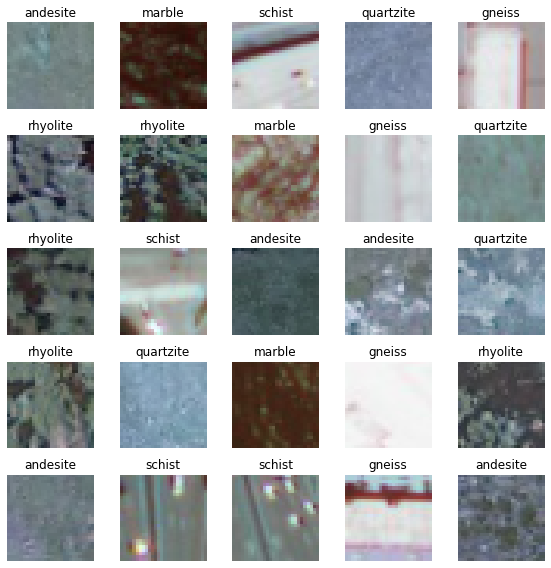

In [3]:
geo_data, tfms = load_lib.load_and_restruct_data(dir_path = conf_lib.dir_path,
                                                 image_folder = conf_lib.image_folder,
                                                 image_size = conf_lib.image_size,
                                                 ratio_train = conf_lib.ratio_train,
                                                 ratio_test = conf_lib.ratio_test,
                                                 ratio_valid = conf_lib.ratio_valid,
                                                 data_folder_list = conf_lib.data_folder_list,
                                                 class_folder_list = conf_lib.class_folder_list,
                                                 aws_url = conf_lib.aws_url,
                                                 seed=42)

print('geological image data loaded')
print('{0} classes are:'.format(geo_data.c))
print('     ',geo_data.classes)
print('Train dataset size: {0}'.format(len(geo_data.train_ds.x)),'images')
print('Test dataset size: {0}'.format(len(geo_data.valid_ds.x)),'images')

print('Given data with labels as shown below:')
geo_data.show_batch(rows=5, figsize=(8,8))

### 4.0 Model Development
In this section step-by-step codes for developing and storing a CNN model are presented.

#### Load a CNN model using 80% of the images

- Using the pretrained weights resnet34 model (transfer learning)
reference: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
- To find ideal learning rate in fastai, refer: https://docs.fast.ai/callbacks.lr_finder.html#LRFinder
- Based on paper "Cyclical Learning Rates for Training Neural Networks" by Leslie N. Smith (V6, April 2017). Refer: https://arxiv.org/abs/1506.01186

In [4]:
## Creating the model by chosing resnet34 architecture
arch = models.resnet34
learn = cnn_learner(geo_data, arch, pretrained=True, metrics=[accuracy, error_rate])

- This initial layers are mostly used for understanding low-level features like curves, lines, shapes, patterns from a large dataset with large number of categories like Imagenet

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 1.74E-02


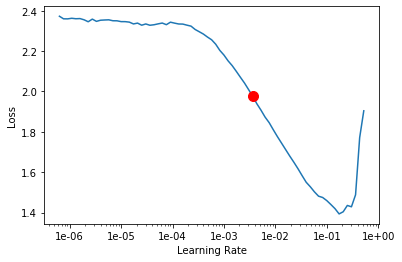

In [5]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_0 = learn.recorder.min_grad_lr

#### LR Finder indication:
- We choose a value that is approximately in the middle of the sharpest downward slope
- Train the last layer group only in next step (2 epochs) to prevent overfitting at this stage after getting the best suited learning rate as shown above
- Save the model weights 

In [6]:
print('Suggested minimum numerical gradient:', lib.format_decimal(min_grad_0))
learn.fit_one_cycle(2, 1e-2)
print('saving the model under', conf_lib.image_folder + 'models/')
learn.save('model1-rn34')

Suggested minimum numerical gradient: 3.63e-3


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.162914,0.140916,0.949983,0.050017,10:39
1,0.088624,0.061819,0.980327,0.019673,02:03


saving the model under /home/pr916/notebooks/geo_image_problem/geological_similarity/models/


#### Unfreezed the layers, train model and save
- Unfreeze the layers so that all weights from frozen layers can get updated from their pre-trained state
- Use lr_find() again to train the model around best suitable learning rate
- Use thumb rule of range of learning rates from 1/10 of above model and the new suggested learning rate below (reference: fastai course v3 - lesson 2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.10E-07


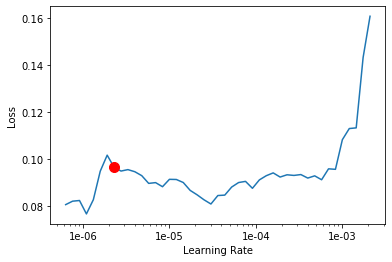

In [7]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_1 = learn.recorder.min_grad_lr

In [8]:
print('Suggested minimum numerical gradient:', lib.format_decimal(min_grad_1))
learn.fit_one_cycle(3, slice(1e-5, 1e-2/5))

Suggested minimum numerical gradient: 2.29e-6


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.106151,0.045655,0.985328,0.014672,05:20
1,0.072869,0.041387,0.984662,0.015338,05:03
2,0.053349,0.038932,0.987663,0.012337,05:14


In [9]:
print('saving the enhanced model with fine tuning using previous model weights')
learn.save('GI-model')

saving the enhanced model with fine tuning using previous model weights


### 5.0 Model Insights

Some insites from the above model are presented below:
- Most confused interpretation (quartzite and andesite have instances with many similar images)
- Test accuracy of the trained model
- Some top differences in predicting images
- model accuracy for train, test and validation sets

In [10]:
learn.interpret().most_confused(min_val=2)

[('quartzite', 'andesite', 24),
 ('andesite', 'rhyolite', 6),
 ('gneiss', 'schist', 2),
 ('rhyolite', 'andesite', 2),
 ('schist', 'gneiss', 2)]

In [11]:
df_cm = pd.DataFrame(learn.interpret().confusion_matrix(), 
                     index = geo_data.classes,
                     columns = geo_data.classes)

df_cm

,andesite,gneiss,marble,quartzite,rhyolite,schist
andesite,494,0,0,0,6,0
gneiss,0,498,0,0,0,2
marble,0,0,499,0,0,0
quartzite,24,0,0,475,1,0
rhyolite,2,0,0,0,498,0
schist,0,2,0,0,0,498


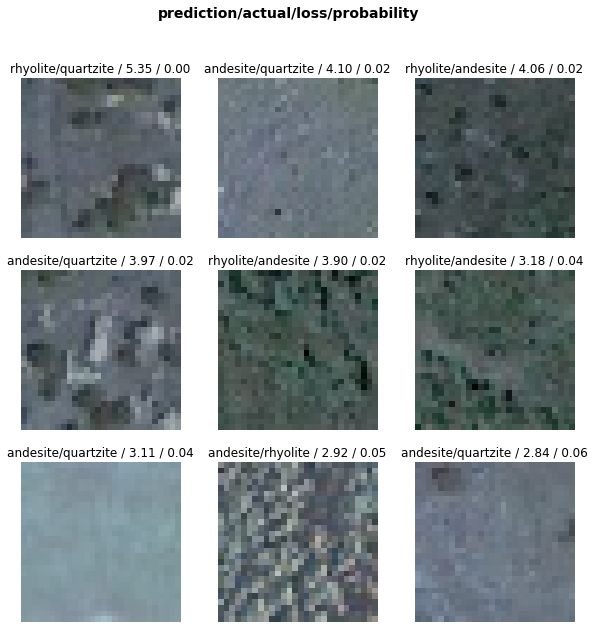

In [12]:
learn.interpret().plot_top_losses(9, figsize=(10,10))

In [13]:
train_accuracy = lib.get_accuracy(learn.validate(learn.data.train_dl))

valid_accuracy = lib.get_accuracy(learn.validate(learn.data.valid_dl))

# Use of data block API to test accuracy for test data
data_test = (ImageList.from_folder(conf_lib.image_folder)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize())

test_accuracy = lib.get_accuracy(learn.validate(data_test.valid_dl))

In [14]:
print('accuracy for train data: ', train_accuracy, '%', sep='')
print('accuracy for validation data: ', valid_accuracy, '%', sep='')
print('accuracy for test data: ', test_accuracy, '%', sep='')

accuracy for train data: 98.7%
accuracy for validation data: 98.77%
accuracy for test data: 78.57%


### 6.0 Image Similarity Function 

In [ ]:
# Hook (refer: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [ ]:
sf = SaveFeatures(learn.model[1][4])

In [ ]:
learn.get_preds(geo_data.train_ds)

In [ ]:
_= learn.get_preds(geo_data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [ ]:
img_path = [str(x) for x in (list(geo_data.train_ds.items)+ \
                                   list(geo_data.valid_ds.items)+list(data_test.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [ ]:
path = pathlib.Path(conf_lib.image_folder)

In [ ]:
## Exporting as pickle
pickle.dump(feature_dict, open(path/"feature_dict.p", "wb"))

In [ ]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

In [ ]:
## Exporting as pickle
pickle.dump(lsh, open(path/'lsh.p', "wb"))

In [ ]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

In [ ]:
len(list(feature_dict.keys()))

In [ ]:
class Hook():
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
        
def get_output(module, input_value, output):
    return output.flatten(1)

def get_input(module, input_value, output):
    return list(input_value)[0]

def get_named_module_from_model(model, name):
    for n, m in model.named_modules():
        if n == name:
            return m
    return None
    
linear_output_layer = get_named_module_from_model(model, '1.4')

# getting all images in train
train_valid_images_df = data_df[data_df['dataset'] != 'test']
inference_data_source = (ImageList.from_df(df=train_valid_images_df, path=images_path, cols='images')
                    .split_none()
                    .label_from_df(cols='category')
              )
              
inference_data = inference_data_source.transform(tmfs, size=224).databunch(bs=64).normalize(imagenet_stats)

# turning off shuffle
inference_dataloader = inference_data.train_dl.new(shuffle=False)

import time
img_repr_map = {}

with Hook(linear_output_layer, get_output, True, True) as hook:
    start = time.time()
    for i, (xb, yb) in enumerate(inference_dataloader):
        bs = xb.shape[0]
        img_ids = inference_dataloader.items[i*bs: (i+1)*bs]
        result = model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(bs, -1)
        for img_id, img_repr in zip(img_ids, img_reprs):
            img_repr_map[img_id] = img_repr
        if(len(img_repr_map) % 12800 == 0):
            end = time.time()
            print(f'{end-start} secs for 12800 images')
            start = end
            
img_repr_df = pd.DataFrame(img_repr_map.items(), columns=['img_id', 'img_repr'])
img_repr_df['label'] = [inference_data.classes[x] for x in inference_data.train_ds.y.items[0:img_repr_df.shape[0]]]


In [ ]:
def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label  = img_repr_df.iloc[img_index, [0, 1, 2]]
    cosine_similarity = 1 - img_repr_df['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, base_label, img_repr_df.iloc[similar_img_ids]

In [ ]:
from annoy import AnnoyIndex

feature_dim = len(img_repr_df['img_repr'][0])
t = AnnoyIndex(feature_dim, metric='euclidean')

for i, vector in enumerate(img_repr_df['img_repr']):
    t.add_item(i, vector)
    
_  = t.build(inference_data.c)

In [ ]:
def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = img_repr_df.iloc[img_index, [0, 1, 2]]
    similar_img_ids = t.get_nns_by_item(img_index, 13)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, img_repr_df.iloc[similar_img_ids[1:]]
    
base_image, base_label, similar_images_df = get_similar_images_annoy(212693)

#### Appendix A: split_data_folder

#### Appendix B: GI_main.py

In [ ]:
geo_data.valid_ds

#### Appendix C: GI_load.py